# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Read the Dataset

In [2]:
# read and concatenate the datasets (original and extra data)
df = pd.read_csv("/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv")
df1 = pd.read_csv("/kaggle/input/playground-series-s3e12/train.csv")
train_set = pd.concat([df1.iloc[:,1:],df], axis=0)
test_set = pd.read_csv("/kaggle/input/playground-series-s3e12/test.csv")
train_set

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...
74,1.025,7.90,721,23.6,301,9.04,1
75,1.017,4.81,410,13.3,195,0.58,1
76,1.024,5.40,803,21.8,394,7.82,1
77,1.016,6.81,594,21.4,255,12.20,1


In [3]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 0 to 78
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  493 non-null    float64
 1   ph       493 non-null    float64
 2   osmo     493 non-null    int64  
 3   cond     493 non-null    float64
 4   urea     493 non-null    int64  
 5   calc     493 non-null    float64
 6   target   493 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 30.8 KB


In [4]:
# check if it is categorical data
for i in train_set.columns:
    print(i + " num of uniques: %.1f" %(train_set[i].nunique()))

gravity num of uniques: 29.0
ph num of uniques: 75.0
osmo num of uniques: 80.0
cond num of uniques: 67.0
urea num of uniques: 74.0
calc num of uniques: 86.0
target num of uniques: 2.0


In [5]:
# check skewness
for i in train_set.columns[:-1]:
    print(i +  " skewness: %.4f" %(skew(train_set[i])))

gravity skewness: 0.2995
ph skewness: 0.9279
osmo skewness: 0.1451
cond skewness: -0.1821
urea skewness: 0.3293
calc skewness: 1.1155


In [8]:
# check if there's nan values for new features
train_set.isnull().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

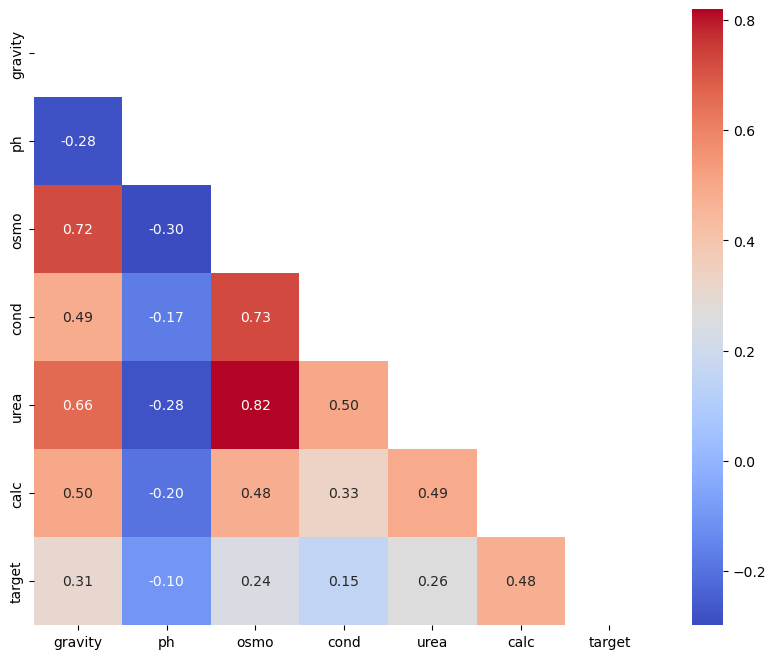

In [10]:
# feature correlation
plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(train_set.corr(), dtype=bool))
sns.heatmap(train_set.corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask);

In [ ]:
# checking feature importance
model1 = RandomForestClassifier()
model1.fit(train_set.iloc[:,:-1], train_set.iloc[:,-1])

importance = model1.feature_importances_
# create dataframe to test feature importance
feature_importance = pd.DataFrame({"Features": train_set.columns[:-1], 
                                   "Importance": importance})

feature_importance = feature_importance.sort_values("Importance")
plt.bar(feature_importance["Features"], feature_importance["Importance"])
plt.ylabel("Feature Importance");

# Train Model

In [ ]:
# 5 cross validation with roc auc score
def train_model(model, X_train, y_train, X_test,cv=5):
    '''
    inputs:
    
    model: Train model you selected 
    X_train: The features you used to train the model
    y_train: The target you used to train the model
    X_test: The features you used to predict the model 
    cv_num: The number of folds split to use for cross validation
    
    output:
    
    y_pred: The target values you predicted
    '''
    # check type (must be numpy)
    check_dict = {"X_train": X_train, "y_train": y_train, "X_test": X_test}
    for key, value in check_dict.items():
        if not isinstance(value, np.ndarray):
            raise ValueError (f"{key} must be a numpy array.")
            
    # split k fold
    stratkfold = StratifiedKFold(n_splits=cv)
    kfold = stratkfold.split(X_train, y_train)
    
    score_list = []
    
    # start setting the cross validation 
    for k, (train_idx, val_idx) in enumerate(kfold, 1):
        ## fit and predict the model 
        model.fit(X_train[train_idx,:], y_train[train_idx])
        y_pred = model.predict_proba(X_train[val_idx,:])[:,1]
        
        ## get and print the metric
        roc_score = roc_auc_score(y_train[val_idx], y_pred)
        score_list.append(roc_score)
        print("Fold: %.1f, AUC under ROC curve: %.4f "%(k, roc_score))
        
    print("Total Cross validation is %.4f +/- %.4f"%(np.mean(score_list), np.std(score_list)))
    
    y_pred = model.predict_proba(X_test)[:,1]
    return y_pred #, model.coef_.round(2)

# Feature Engineering Experiments 

## feature construction 

In [7]:
# feature construction 
## (6-10 features)
train_set["urea_to_osmo"] = train_set["urea"]/train_set["osmo"]
train_set["cal_to_osmo"] = train_set["calc"]/train_set["osmo"]
train_set["urea_to_cond"] = train_set["urea"]/train_set["cond"]
train_set["cal_to_cond"] = train_set["calc"]/train_set["cond"]
train_set["urea_to_cal"] = train_set["urea"]/train_set["calc"]

## other construction features
train_set["iron_product"] = train_set["calc"]*train_set["urea"]
train_set["elect_balance"] = train_set["cond"]/(10**(-train_set["ph"]))
train_set["osmo_to_gravity"] = train_set["osmo"]/train_set["gravity"]
train_set["osmo_density"] = train_set["osmo"]*train_set["gravity"]

In [ ]:
# add new features to the test set
## (6-10 features)
test_set["urea_to_osmo"] = test_set["urea"]/test_set["osmo"]
test_set["cal_to_osmo"] = test_set["calc"]/test_set["osmo"]
test_set["urea_to_cond"] = test_set["urea"]/test_set["cond"]
test_set["cal_to_cond"] = test_set["calc"]/test_set["cond"]
test_set["urea_to_cal"] = test_set["urea"]/test_set["calc"]

## other construction features
test_set["iron_product"] = test_set["calc"]*test_set["urea"]
test_set["elect_balance"] = test_set["cond"]/(10**(-test_set["ph"]))
test_set["osmo_to_gravity"] = test_set["osmo"]/test_set["gravity"]
test_set["osmo_density"] = test_set["osmo"]*test_set["gravity"]

In [ ]:
# keep cond: 
## best 1-5:
train_set['cond_to_osmo'] = train_set['cond']/train_set['osmo']
test_set['cond_to_osmo'] = test_set['cond']/test_set['osmo']

## test: drop some less important features 
new_set = train_set.drop(columns=["osmo", "urea_to_osmo", "urea_to_cond",
                                 "ph"], axis=1)
new_test = test_set.drop(columns=["osmo", "urea_to_osmo", "urea_to_cond",
                                "ph"], axis=1)
# inputs 
rf = RandomForestClassifier()
X_train, y_train = new_set.drop("target", axis=1).to_numpy(), new_set["target"].to_numpy()
X_test = new_test.drop("id", axis=1).to_numpy()

# output
y_pred, model_params = train_model(rf, X_train, y_train, X_test)
# save the submission 
pred_outcome = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([new_test['id'], pred_outcome], axis=1)
submission_df.to_csv("submission.csv", index=False)

In [ ]:
# keep cond and best 1-5:
train_set['cond_to_osmo'] = train_set['cond']/train_set['osmo']
test_set['cond_to_osmo'] = test_set['cond']/test_set['osmo']

## test: drop some less important features 
new_set = train_set.drop(columns=["osmo", "urea_to_osmo", "urea_to_cond",
                                 "ph"], axis=1)
new_test = test_set.drop(columns=["osmo", "urea_to_osmo", "urea_to_cond",
                                "ph"], axis=1)
# inputs 
rf = RandomForestClassifier()
X_train, y_train = new_set.drop("target", axis=1).to_numpy(), new_set["target"].to_numpy()
X_test = new_test.drop("id", axis=1).to_numpy()

# output
y_pred, model_params = train_model(rf, X_train, y_train, X_test)
# save the submission 
pred_outcome = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([new_test['id'], pred_outcome], axis=1)
submission_df.to_csv("submission.csv", index=False)

## add aggregating features

In [ ]:
# generate the groupby mean and std
def agg_fun(group_set, data_set, agg_cols, agg_methods=['mean', 'std']):
    '''
    inputs:
    group_set: set the group how to combine
    data_set: the dataset used to group by
    agg_cols: all columns consider to extract the aggregate results
    agg_methods: the methods of aggregating the data
    '''
    # save all new aggregate results
    all_agg = []
    for col in agg_cols:
        agg_df = data_set.groupby(group_set)[col].aggregate(agg_methods)
        merge_df = pd.merge(data_set, agg_df, left_on=group_set, right_index=True, how='left')
        merge_df.fillna(data_set[col].median(), inplace=True)
        all_agg.append(merge_df.iloc[:,-2:].to_numpy())
        
    final_agg = pd.DataFrame(np.concatenate(all_agg, axis=1))
    
    return final_agg

In [ ]:
# train set
agg_cols = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
group_col = [['gravity'],['calc'], ['urea'], ['osmo']

#               ['calc', 'urea'], 
#               ['gravity', 'calc', 'urea']]

concat_set = []
for col in group_col:
    group_agg = agg_fun(col,train_set,agg_cols)
    concat_set.append(group_agg)
    
concat_np = np.concatenate(concat_set, axis=1)
final_np = np.concatenate((train_set.drop('target', axis=1).to_numpy(), concat_np), axis=1)


concat_set1 = []
for col in group_col:
    group_agg = agg_fun(col,test_set,agg_cols)
    concat_set1.append(group_agg)
    
concat_np1 = np.concatenate(concat_set1, axis=1)
final_np1 = np.concatenate((test_set.drop('id', axis=1).to_numpy(), concat_np1), axis=1)

# Traditional ML Models

In [ ]:
# common libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

model_list = [LogisticRegression(), DecisionTreeClassifier(),
             RandomForestClassifier(n_estimators=100), GaussianNB(),
             SVC(kernel='linear', probability=True),
xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100),
             MLPClassifier(hidden_layer_sizes=(50, 50), random_state=42)]

In [13]:
# no transformation 
# based random forest model

# inputs 
rf = RandomForestClassifier()
X_train, y_train = train_set.iloc[:,:-1].to_numpy(), train_set.iloc[:,-1].to_numpy()
X_test = test_set.iloc[:,1:].to_numpy()

# output
y_pred, model_params = train_model(rf, X_train, y_train, X_test)

# save the submission 
pred_outcome = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([test_set['id'], pred_outcome], axis=1)
submission_df.to_csv("submission.csv", index=False)

Fold: 1.0, AUC under ROC curve: 0.8718 
Fold: 2.0, AUC under ROC curve: 0.6761 
Fold: 3.0, AUC under ROC curve: 0.7687 
Fold: 4.0, AUC under ROC curve: 0.8418 
Fold: 5.0, AUC under ROC curve: 0.8104 
Fold: 6.0, AUC under ROC curve: 0.8165 
Fold: 7.0, AUC under ROC curve: 0.8476 
Fold: 8.0, AUC under ROC curve: 0.7525 
Fold: 9.0, AUC under ROC curve: 0.7677 
Fold: 10.0, AUC under ROC curve: 0.8283 
Total Cross validation is 0.7981 +/- 0.0547


# MLP

In [ ]:
# basic feature transformation
# standardization 
from sklearn.preprocessing import StandardScaler

stand = StandardScaler()
X_train = stand.fit_transform(train_set.drop("target", axis=1))
X_test = stand.fit_transform(test_set.drop("id", axis=1))
y_train = train_set["target"].to_numpy()

# best version is :
mlp17 = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500, activation="logistic")
y_pred, model_params = train_model(mlp17, X_train, y_train, X_test)

In [ ]:
# advanced feature transformation 
# feature construction 
## (6-10 features)
train_set["urea_to_osmo"] = train_set["urea"]/train_set["osmo"]
train_set["cal_to_osmo"] = train_set["calc"]/train_set["osmo"]
train_set["urea_to_cond"] = train_set["urea"]/train_set["cond"]
train_set["cal_to_cond"] = train_set["calc"]/train_set["cond"]
train_set["urea_to_cal"] = train_set["urea"]/train_set["calc"]

## other construction features
train_set["iron_product"] = train_set["calc"]*train_set["urea"]
train_set["elect_balance"] = train_set["cond"]/(10**(-train_set["ph"]))
train_set["osmo_to_gravity"] = train_set["osmo"]/train_set["gravity"]
train_set["osmo_density"] = train_set["osmo"]*train_set["gravity"]

# add new features to the test set
## (6-10 features)
test_set["urea_to_osmo"] = test_set["urea"]/test_set["osmo"]
test_set["cal_to_osmo"] = test_set["calc"]/test_set["osmo"]
test_set["urea_to_cond"] = test_set["urea"]/test_set["cond"]
test_set["cal_to_cond"] = test_set["calc"]/test_set["cond"]
test_set["urea_to_cal"] = test_set["urea"]/test_set["calc"]

## other construction features
test_set["iron_product"] = test_set["calc"]*test_set["urea"]
test_set["elect_balance"] = test_set["cond"]/(10**(-test_set["ph"]))
test_set["osmo_to_gravity"] = test_set["osmo"]/test_set["gravity"]
test_set["osmo_density"] = test_set["osmo"]*test_set["gravity"]

In [ ]:
# keep cond and best 1-5:
train_set['cond_to_osmo'] = train_set['cond']/train_set['osmo']
test_set['cond_to_osmo'] = test_set['cond']/test_set['osmo']

## test: drop some less important features 
new_set = train_set.drop(columns=["osmo", "urea_to_osmo", "urea_to_cond",
                                 "ph"], axis=1)
new_test = test_set.drop(columns=["osmo", "urea_to_osmo", "urea_to_cond",
                                "ph"], axis=1)

X_train = stand.fit_transform(new_set.drop("target", axis=1))
X_test = stand.fit_transform(new_test.drop("id", axis=1))
y_train = train_set["target"].to_numpy()

# best version is :
mlp18 = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500, activation="logistic")
y_pred, model_params = train_model(mlp18, X_train, y_train, X_test)

# Boosting

In [ ]:
# XGBoost
# inputs 
X_train, y_train = train_set.drop("target", axis=1).to_numpy(), train_set["target"].to_numpy()
X_test = test_set.drop("id", axis=1).to_numpy()
model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)
y_pred, model_params = train_model(model,X_train,y_train, X_test)

# output 
pred_df = pd.DataFrame(y_pred, columns=["target"])
final_df = pd.concat([test_set["id"], pred_df], axis=1)
final_df.to_csv("submission.csv", index=False)
final_df

In [ ]:
import lightgbm as lgb

# Train the LightGBM model
model2 = lgb.LGBMClassifier() 
model2.fit(X[layer_2_feats], y_train)
# Predict probabilities for the test set
y_prob = model2.predict_proba(test[layer_2_feats])[:,1]
pred_df = pd.DataFrame(y_prob, columns=['target'])
pred_df

# Voting Strategy

In [ ]:
## random forest + xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test = test_set.drop("id", axis=1)
# estimators = [('forest', RandomForestClassifier(n_estimators=100)),
#               ('xgb', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100))]

estimators = [('forest', RandomForestClassifier(n_estimators=100))]
ensemble_voting4 = VotingClassifier(estimators=estimators, voting='soft')
scores = cross_val_score(ensemble_voting4, X_train, y_train, cv=10,scoring='roc_auc')
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.4f}".format(scores.mean()))
ensemble_voting.fit(X_train, y_train)
y_pred = ensemble_voting.predict_proba(X_test)[:,1]
y_pred = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([test_set["id"], y_pred], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df


In [ ]:
# random forest + xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test = test_set.drop("id", axis=1)
estimators = [('forest', RandomForestClassifier(n_estimators=100)),
              ('xgb', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)),
             ('svm', SVC(kernel='linear', probability=True))]


ensemble_voting2 = VotingClassifier(estimators=estimators, voting='soft')
scores = cross_val_score(ensemble_voting2, X_train, y_train, cv=5,scoring='roc_auc')
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.4f}".format(scores.mean()))

In [ ]:
# random forest + xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test = test_set.drop("id", axis=1)
estimators = [('forest', RandomForestClassifier(n_estimators=100)),
              ('xgb', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)),
             ('svm', SVC(kernel='linear', probability=True))]


ensemble_voting5 = VotingClassifier(estimators=estimators, voting='soft')
scores = cross_val_score(ensemble_voting5, X_train, y_train, cv=10,scoring='roc_auc')
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.4f}".format(scores.mean()))

In [ ]:
# random forest + xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test = test_set.drop("id", axis=1)
estimators = [('forest', RandomForestClassifier(n_estimators=100)),
              ('xgb', xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)),
             ('svm', SVC(kernel='linear', probability=True)),
             ('logr', LogisticRegression())]


ensemble_voting6 = VotingClassifier(estimators=estimators, voting='soft')
scores = cross_val_score(ensemble_voting6, X_train, y_train, cv=10,scoring='roc_auc')
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.4f}".format(scores.mean()))

In [ ]:
# cross validate each model 
def cross_validate(model, X_train, y_train):
    # check type (must be numpy)
    check_dict = {"X_train": X_train, "y_train": y_train}
    for key, value in check_dict.items():
        if not isinstance(value, np.ndarray):
            raise ValueError (f"{key} must be a numpy array.")
            
    # split k fold
    stratkfold = StratifiedKFold(n_splits=5)
    kfold = stratkfold.split(X_train, y_train)
    
    score_list = []
    
    # start setting the cross validation 
    for k, (train_idx, val_idx) in enumerate(kfold, 1):
        ## fit and predict the model 
        model.fit(X_train[train_idx,:], y_train[train_idx])
        y_pred = model.predict_proba(X_train[val_idx,:])[:,1]
        
        ## get and print the metric
        roc_score = roc_auc_score(y_train[val_idx], y_pred)
        score_list.append(roc_score)
        print("Fold: %.1f, AUC under ROC curve: %.4f "%(k, roc_score))
        
    print("Total Cross validation is %.4f +/- %.4f"%(np.mean(score_list), np.std(score_list)))
    
    return model

In [ ]:
m1 = RandomForestClassifier(n_estimators=100)
m2 = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)
m3 = SVC(kernel='linear', probability=True)

tune_models = list()
X_train, y_train = train_set.drop("target", axis=1).to_numpy(), train_set["target"].to_numpy()
X_test = test_set.drop("id", axis=1)

for model in [m1,m2,m3]:
    tune_model = cross_validate(model,X_train, y_train)
    tune_models.append(tune_model)
    

estimators = [('forest', tune_models[0]),
              ('xgb', tune_models[1]),
             ('svm', tune_models[2])]

ensemble_voting5 = VotingClassifier(estimators=estimators, voting='soft')
ensemble_voting5.fit(X_train, y_train)
y_pred = ensemble_voting5.predict_proba(X_test)[:,1]

pred_df = pd.DataFrame(y_pred, columns=['target'])
submission_df = pd.concat([test_set['id'], pred_df], axis=1)
submission_df.to_csv("submission.csv", index=False)

submission_df
    

# Custom Stacking

In [ ]:
# common libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# set the base models 
def get_models():
    models = dict()
    models['logr'] = LogisticRegression()
    models['cart'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['svm'] = SVC(kernel='linear', probability=True)
    models['forest'] = RandomForestClassifier(n_estimators=100)
#     models['bayes'] = GaussianNB() (very bad from all tests)
    models['xgb'] = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)
    models['mlp'] = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500, activation="logistic")
    
    return models

In [ ]:
# evaluate model (5 cross validation)
def validation(model, X_train, y_train, all_pred=False, X_test=None):
    from sklearn.model_selection import train_test_split
    # check type (must be numpy)
    check_dict = {"X_train": X_train, "y_train": y_train}
    for key, value in check_dict.items():
        if not isinstance(value, np.ndarray):
            raise ValueError (f"{key} must be a numpy array.")
            
    # split k fold
#     if all_pred == True: 
#         X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
#                                                      test_size=0.4)
    stratkfold = StratifiedKFold(n_splits=5)
    kfold = stratkfold.split(X_train, y_train)
    
    scores_list = []
    # start setting the cross validation 
    for k, (train_idx, val_idx) in enumerate(kfold, 1):
        ## fit and predict the model 
        model.fit(X_train[train_idx,:], y_train[train_idx])
        y_pred = model.predict_proba(X_train[val_idx,:])[:,1]
        
        ## get and print the metric
        roc_score = roc_auc_score(y_train[val_idx], y_pred)
        scores_list.append(roc_score)
    
    # get meta test after meta Xtrain is best
    if all_pred == True:
        #model.fit(X_train, y_train)
        meta_Xtrain = model.predict_proba(X_train)[:,1]
        meta_Xtest = model.predict_proba(X_test)[:,1]
        
        return meta_Xtrain, meta_Xtest #, y_val
        
    return scores_list

In [ ]:
# plot the based models
import matplotlib.pyplot as plt

## initialization
models = get_models()
X_train, y_train = train_set.drop("target", axis=1).to_numpy(), train_set["target"].to_numpy()

## train and validate for based models
results = dict.fromkeys(list(models.keys()))
for key, model in models.items():
    scores_list = validation(model,X_train,y_train)
    results[key] = scores_list
    print("%s  %.4f (%.4f)"%(key, np.mean(scores_list), np.std(scores_list)))
    
## plot boxplots
labels, data = [*zip(*results.items())] 
plt.boxplot(data, labels=labels, showmeans=True)
plt.show()

In [ ]:
# get diiferent features combinations
## use layer 1 features to predict the target (layer1: based models) get proportion
from tqdm import tqdm
## initialization
models = get_models()
X_train, y_train = train_set.drop("target", axis=1).to_numpy(), train_set["target"].to_numpy()
X_test = test_set.drop("id", axis=1).to_numpy()
layer1_feats = dict.fromkeys(list(models.keys()))
test_feats = dict.fromkeys(list(models.keys()))

# train the base models
for key, model in tqdm(models.items()):
    meta_Xtrain, meta_Xtest = validation(model,X_train,y_train,all_pred=True,X_test=X_test)
    layer1_feats[key] = meta_Xtrain
    test_feats[key] = meta_Xtest
    
# extract all layer 1 features
layer1_metaX = pd.DataFrame(layer1_feats)
test_metaX = pd.DataFrame(test_feats)

In [ ]:
# original + layer1 -> predict
# layer1_metaX = layer1_metaX.reset_index(drop=True)
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)
X_feats = pd.concat([train_set.drop("target", axis=1), layer1_metaX], axis=1)
X_tests = pd.concat([test_set.drop("id", axis=1), test_metaX], axis=1,ignore_index=True)

In [ ]:
# train the model 
X_train, y_train = X_feats.to_numpy(), train_set["target"].to_numpy()
X_test = X_tests.to_numpy()
model = RandomForestClassifier(n_estimators=100)
y_pred = train_model(model,X_train,y_train,X_test,cv=3)

pred_df = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([test_set['id'], pred_df], axis=1)
submission_df.to_csv("submission.csv", index=False)

submission_df

In [ ]:
# get proportion weight for logistic regression 
meta_model = LogisticRegression()
final_pred, weights = train_model(meta_model,layer1_metaX.to_numpy(), 
                                  y_val,test_metaX.to_numpy())

pred_df = pd.DataFrame(final_pred, columns=["target"])
submission_df = pd.concat([test_set['id'], pred_df], axis=1)
submission_df.to_csv("submission.csv", index=False)

submission_df

In [ ]:
# get proporation 
meta_weights = pd.DataFrame(weights.reshape(-1,1), 
                            index=models.keys(), columns=["weights"])
meta_weights

In [ ]:
# no 5cv before 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## initialization
models = get_models()
X_train, y_train = train_set.drop("target", axis=1).to_numpy(), train_set["target"].to_numpy()
X_test = test_set.drop("id", axis=1).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.4)

layer1_feats = dict.fromkeys(list(models.keys()))
test_feats = dict.fromkeys(list(models.keys()))

meta_Xtrain = list()

# train the base models
for key, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    layer1_feats[key] = model.predict_proba(X_val)[:,1]
    test_feats[key] = model.predict_proba(X_test)[:,1]
    
meta_Xtrain = pd.DataFrame(layer1_feats)
meta_Xtest = pd.DataFrame(test_feats)

meta_model = LogisticRegression()
y_pred, weights = train_model(meta_model,meta_Xtrain.to_numpy(),y_val,
                              meta_Xtest.to_numpy())

In [ ]:
# second layer 
# no 5cv before 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## initialization
models = get_models()
X_train, y_train = train_set.drop("target", axis=1).to_numpy(), train_set["target"].to_numpy()
X_test = test_set.drop("id", axis=1).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.4)

layer1_feats = dict.fromkeys(list(models.keys()))
test_feats = dict.fromkeys(list(models.keys()))

meta_Xtrain = list()

# train the base models
for key, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    layer1_feats[key] = model.predict_proba(X_val)[:,1]
    test_feats[key] = model.predict_proba(X_test)[:,1]
    
meta_Xtrain = pd.DataFrame(layer1_feats)
meta_Xtest = pd.DataFrame(test_feats)

meta_model = LogisticRegression()
layer2_lr = train_model(meta_model,meta_Xtrain.to_numpy(),y_val,   
                           meta_Xtest.to_numpy())

In [ ]:
from lightgbm import LGBMClassifier

meta_model2 = LGBMClassifier()
layer2_lgb = train_model(meta_model2,meta_Xtrain.to_numpy(),y_val,
                              meta_Xtest.to_numpy())
pred_df = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([test_set['id'], pred_df], axis=1)
submission_df.to_csv("submission.csv", index=False)

submission_df

In [ ]:
# get proporation 
meta_weights = pd.DataFrame(weights.reshape(-1,1), 
                            index=models.keys(), columns=["weights"])
meta_weights

In [ ]:
# try get stacking 
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier

X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test = test_set.drop("id", axis=1)



meta_model = LogisticRegression()

m1= LogisticRegression()
m2 = DecisionTreeClassifier()
m3 = KNeighborsClassifier()
m4 = SVC(kernel='linear', probability=True)
m5 = RandomForestClassifier(n_estimators=100)
m6 = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)
m7 = MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50, 50),max_iter=500)

stacking = StackingClassifier(classifiers=[m1,m2,m3,m4,m5,m6,m7],use_probas=True,
                             meta_classifier=meta_model)

print('5-fold cross validation:\n')

for clf, label in zip([m1,m2,m3,m4,m5,m6,m7,stacking], 
                      ['logr','cart','knn','svm','forest','xgb','mlp','StackingClassifier']):

    scores = cross_val_score(clf,X_train, y_train,cv=5,scoring='roc_auc')
    print("ROC_AUC: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))


In [ ]:
# try to combine 2 layer
## second layer
meta_model1 = LogisticRegression()
meta_model2 = lgb.LGBMClassifier()

m1= LogisticRegression()
m2 = DecisionTreeClassifier()
m3 = KNeighborsClassifier()
m4 = SVC(kernel='linear', probability=True)
m5 = RandomForestClassifier(n_estimators=100)
m6 = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.1, n_estimators=100)
m7 = MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50, 50),max_iter=500)

stacking1 = StackingClassifier(classifiers=[m1,m2,m3,m4,m5,m6,m7],use_probas=True,
                             meta_classifier=meta_model1)

stacking2 = StackingClassifier(classifiers=[m1,m2,m3,m4,m5,m6,m7],use_probas=True,
                             meta_classifier=meta_model2)

print('5-fold cross validation:\n')

for clf, label in zip([stacking1, stacking2], 
                      ['Stacking_LR', 'Stacking_LGBM']):

    scores = cross_val_score(clf,X_train, y_train,cv=5,scoring='roc_auc')
    print("ROC_AUC: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))



layer2_lr = stacking1.predict_proba(X_test)
layer2_lgb = stacking2.predict_proba(X_test)

layer2_feats = np.hstack((layer2_lr, layer2_lgb))

In [ ]:
# get proportion weight for logistic regression 
meta_model = LogisticRegression()
meta_model.fit(layer1_metaX, y_train)

final_pred = meta_model.predict_proba(test_metaX)[:,1]
pred_df = pd.DataFrame(final_pred, columns=["target"])
submission_df = pd.concat([test_set['id'], pred_df], axis=1)
submission_df.to_csv("submission.csv", index=False)

submission_df


In [ ]:
# get proporation 
meta_weights = pd.DataFrame(meta_model.coef_.round(2).reshape(-1,1), 
                            index=models.keys(), columns=["weights"])
meta_weights

In [ ]:
# based test: use layer 1 features to predict the target (layer1: based models)
#very bad 0.78 + 
# get proportion weight for LGBM
meta_model1 = lgb.LGBMClassifier()
meta_model1.fit(layer1_metaX, y_train)

final_pred1 = meta_model1.predict_proba(test_metaX)[:,1]
pred_df = pd.DataFrame(final_pred1, columns=['target'])
submission_df = pd.concat([test_set['id'], pred_df], axis=1)
submission_df.to_csv("submission.csv", index=False)

submission_df


In [ ]:
# get proporation 
all_sum = np.sum(meta_model1.feature_importances_)
meta_weights1 = pd.DataFrame((meta_model1.feature_importances_.reshape(-1,1)/all_sum).round(2), 
                            index=models.keys(), columns=["weights"])
meta_weights1

# Verstack Stacking

In [ ]:
pip install verstack

In [ ]:
from verstack import Stacker

# settings specific to auto mode:
stacker = Stacker(objective = 'binary',
                  auto = True)

In [ ]:
X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X = stacker.fit_transform(X_train, y_train)

In [ ]:
# get lists of features created in each layer
layer_1_feats = stacker.stacked_features['layer_1']
layer_2_feats = stacker.stacked_features['layer_2']
X_test = test_set.drop("id", axis=1)
test = stacker.transform(X_test)

In [ ]:
# use feature 1 only
model1 = LogisticRegression()
y_pred = train_model(model1, X[layer_1_feats].to_numpy(),
                    y_train.to_numpy(),test[layer_1_feats].to_numpy())


In [ ]:
# use feature 2 only 
model4 = LogisticRegression()

y_pred1 = train_model(model4, X[layer_2_feats].to_numpy(),
                      y_train.to_numpy(), test[layer_2_feats].to_numpy())
y_pred1 = pd.DataFrame(y_pred1, columns=["target"])
submission_df = pd.concat([test_set["id"], y_pred1], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df

In [ ]:
# use feature 1 + feature 2 
model2 = LogisticRegression()

X_train1 = np.concatenate((X[layer_1_feats].to_numpy(), X[layer_2_feats].to_numpy()), axis=1)
X_test1 = np.concatenate((test[layer_1_feats].to_numpy(), test[layer_2_feats].to_numpy()), axis=1)

y_pred1 = train_model(model2, X_train1, y_train.to_numpy(), X_test1)
y_pred1 = pd.DataFrame(y_pred1, columns=["target"])
submission_df = pd.concat([test_set["id"], y_pred1], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df

In [ ]:
# all features
model3 = LogisticRegression()
y_pred2 = train_model(model3, X.to_numpy(), y_train.to_numpy(), test.to_numpy())
y_pred2 = pd.DataFrame(y_pred2, columns=["target"])
submission_df = pd.concat([test_set["id"], y_pred2], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df

In [ ]:
# meta training
model = LogisticRegression()
model.fit(X[layer_1_feats], y_train)
y_pred = model.predict_proba(test[layer_1_feats])[:,1]
y_pred = pd.DataFrame(y_pred, columns=["target"])
submission_df = pd.concat([test_set["id"], y_pred], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df

In [20]:
submission_df

,id,target
0,414,0.180000
1,415,0.550000
2,416,0.930000
3,417,0.400464
4,418,0.300000
...,...,...
271,685,0.660000
272,686,0.020000
273,687,0.660000
274,688,0.050000
